In [1]:
# Jupyter 魔法函数，在当前页面输出图像
%matplotlib inline

In [2]:
# 科学计算
import numpy as np
# 数据处理及导入导出
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
plt.style.use('ggplot') #使用 ggplot 主题
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
# 更好的可视化效果
import seaborn as sns
sns.set_style("whitegrid") #设置 Seaborn 主题
sns.set(font='SimHei')  # 解决 Seaborn 中文显示问题

# 词云
from wordcloud import WordCloud, STOPWORDS
from imageio import imread

# 正则表达式
import re
# 默认字典
from collections import defaultdict

In [3]:
# 导入数据集
df = pd.read_csv('job_skills.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
Company                     1250 non-null object
Title                       1250 non-null object
Category                    1250 non-null object
Location                    1250 non-null object
Responsibilities            1235 non-null object
Minimum Qualifications      1236 non-null object
Preferred Qualifications    1236 non-null object
dtypes: object(7)
memory usage: 68.4+ KB


In [5]:
df.sample(5)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
492,Google,Search Specialist (Swedish),Sales & Account Management,"Dublin, Ireland",Optimize the value of client accounts by analy...,BA/BS degree or equivalent practical experienc...,Relevant experience in creating online marketi...
1022,Google,Senior Credit Research Analyst,Finance,"Sunnyvale, CA, United States",Conduct fundamental credit research of investm...,6 years of credit research experience with a f...,MBA and/or CFA\nExperience covering Capital Go...
199,Google,"Technical Program Manager, Angular",Program Management,"Mountain View, CA, United States",Drive the engineering coordination and executi...,"BS degree in Computer Science, Engineering, Ma...",Demonstrated technical aptitude and strong ana...
534,Google,"Platform Sales Manager, Media Platforms Accoun...",Sales & Account Management,"Berlin, Germany",Drive Google’s relationship with all levels of...,BA/BS degree or equivalent practical experienc...,Experience in the adtech market (buy or sell-s...
316,Google,"Quantitative Analyst, Ads Quality",Product & Customer Support,"Zürich, Switzerland",Apply advanced statistical methods and work wi...,PhD in Statistics or Econometrics or a related...,Relevant industry or research experience.\nFam...


In [6]:
# 修改 DataFrame 列名
df.columns = ['公司名称', '职位名称', '职位类别', '工作地点', '岗位职责', '最低资格', '首选资格']

In [7]:
# 检查是否含有 NaN 值
pd.isnull(df).sum()

公司名称     0
职位名称     0
职位类别     0
工作地点     0
岗位职责    15
最低资格    14
首选资格    14
dtype: int64

In [8]:
# 删除含 NaN 值的列
df = df.dropna(how='any', axis='rows')

In [9]:
df['公司名称'].value_counts()

Google     1212
YouTube      23
Name: 公司名称, dtype: int64

In [10]:
# 删除 YouTube
df = df[df['公司名称'] != 'YouTube']

In [11]:
df['工作城市'] = df['工作地点'].apply(lambda x : x.split(',')[0])
df['工作国家'] = df['工作地点'].apply(lambda x : x.split(',')[-1])

In [12]:
df.describe()

,公司名称,职位名称,职位类别,工作地点,岗位职责,最低资格,首选资格,工作城市,工作国家
count,1212,1212,1212,1212,1212,1212,1212,1212,1212
unique,1,761,23,91,784,788,802,90,49
top,Google,Business Intern 2018,Sales & Account Management,"Mountain View, CA, United States",Responsibilities and detailed projects will be...,Must be pursuing a full-time MBA program with ...,Interest in the technology industry and Google...,Mountain View,United States
freq,1212,35,167,187,33,32,32,187,607


In [13]:
def top15_bar(df, series):
    """
        生成前 15 的条形图
        
        Args:
            df: DataFrame Name, DataFrame
            series: Series name, string
    """
    f, ax = plt.subplots(figsize=(12, 6))
    
    top15 = df[series].value_counts()[0:15]
    
    title = series + ' TOP 15'
    x = top15.values
    y = top15.index
    
    ax.set(title=title)
    sns.set_color_codes("muted")
    sns.barplot(x=x, y=y, color='b');

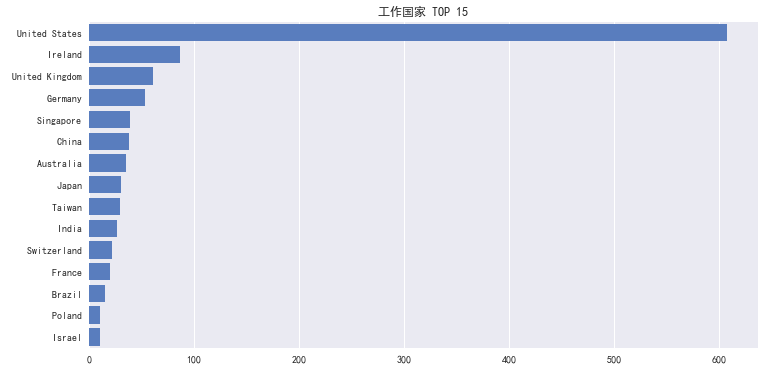

In [14]:
top15_bar(df, '工作国家')

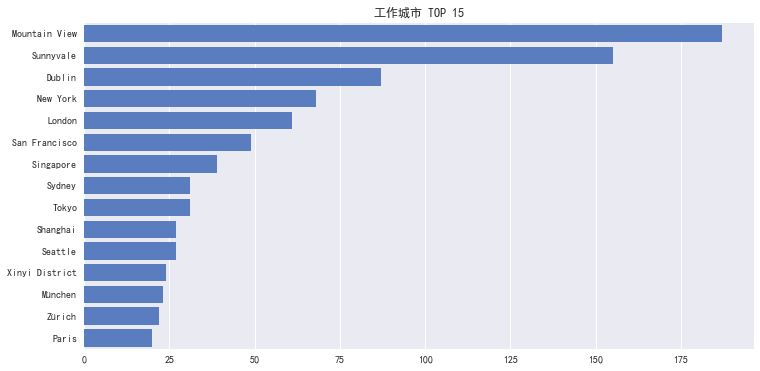

In [15]:
top15_bar(df, '工作城市')

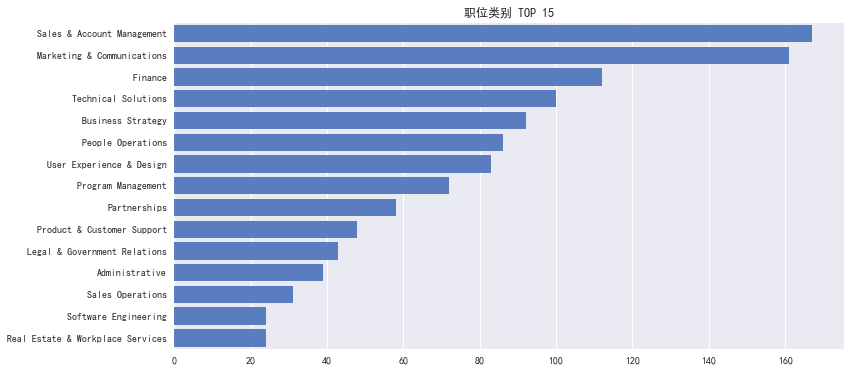

In [16]:
top15_bar(df, '职位类别')

In [17]:
# 编程语言列表
programing_language_list = ['java', 'c', 'c++', 'python', 'c#', 'php', 'javascript', 'sql', 'objective-c', 
                            'swift', 'ruby', 'r', 'matlab', 'perl', 'go', 'kotlin']

In [18]:
def tostr(df, series):
    """
        将指定 Series 转换为字符串
        
        Args:
            df: DataFrame name, DataFrame
            series: Series name, string
            
        Returns:
            string
    """
    list_temp = df[series].tolist() #先转换成列表
    string_temp =  "".join(str(v) for v in list_temp).lower()
    
    return string_temp

In [19]:
minimum_qualifications = tostr(df, '最低资格')

In [20]:
def word_count(countstr, wordlist):
    """
        对指定词语进行计数
        
        Args:
            countstr: target string, string
            wordlist: words to count, list
            
        Returns:
            DataFrame
    """    
    wordcount = dict((x,0) for x in wordlist)
    for w in re.findall(r"[\w']+|[.,!?;’]", countstr):
        if w in wordcount:
            wordcount[w] += 1
            
    result = sorted(wordcount.items(), key=lambda kv: kv[1], reverse=True) #对结果进行排序
    df_temp = pd.DataFrame(result, columns=['Item','Frequency']) #转换为 DataFrame
    df_temp['Item'] = df_temp['Item'].str.capitalize()
    
    return df_temp

In [21]:
programming_lang_count = word_count(minimum_qualifications, programing_language_list)

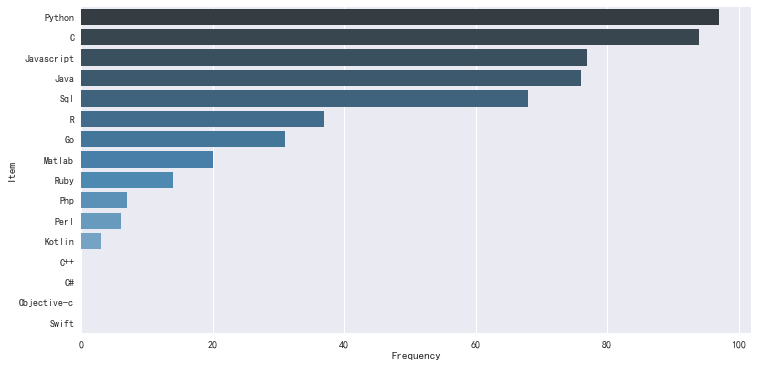

In [22]:
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="Frequency",  y="Item", data=programming_lang_count, palette="Blues_d");

In [23]:
degree_list = ["ba", "bs", "bachelor", "mba", "master", "phd"]

In [24]:
degree_count = word_count(minimum_qualifications, degree_list)

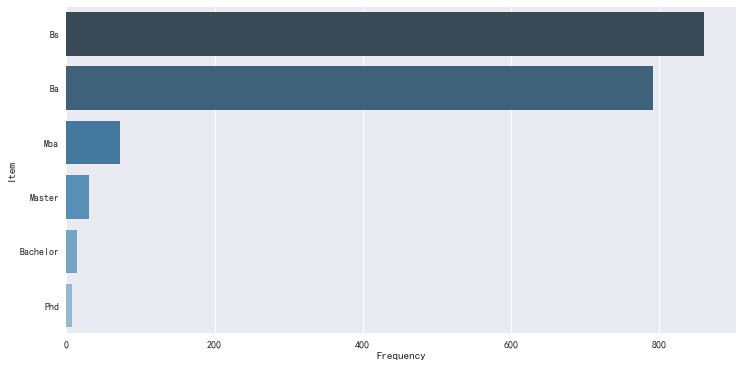

In [25]:
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="Frequency",  y="Item", data=degree_count, palette="Blues_d");

In [26]:
years_exp = defaultdict(lambda: 0)
for w in re.findall(r'([0-9]+) year', minimum_qualifications):
     years_exp[w] += 1
             
df_years_exp = pd.DataFrame.from_dict(years_exp, 'index') #创建一个新的 DataFrame   
df_years_exp = df_years_exp.reset_index()
df_years_exp.columns = ['Years', 'Frequency']
df_years_exp = df_years_exp.astype('int') #转换为整型
df_years_exp.sort_values(by='Years', inplace=True)

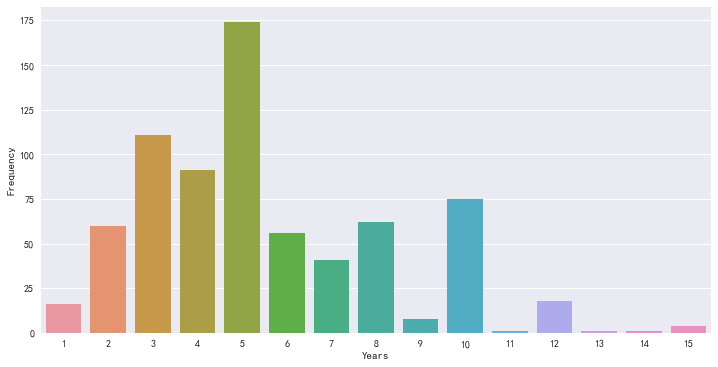

In [27]:
f, ax = plt.subplots(figsize=(12, 6))
with sns.color_palette("husl", 8):
    sns.barplot(x="Years",  y="Frequency", data=df_years_exp);

In [28]:
df['工作年限'] = df['最低资格'].str.extract(r'([0-9]+) year')

In [29]:
df_cate = df[['职位类别', '工作年限', '工作国家']]

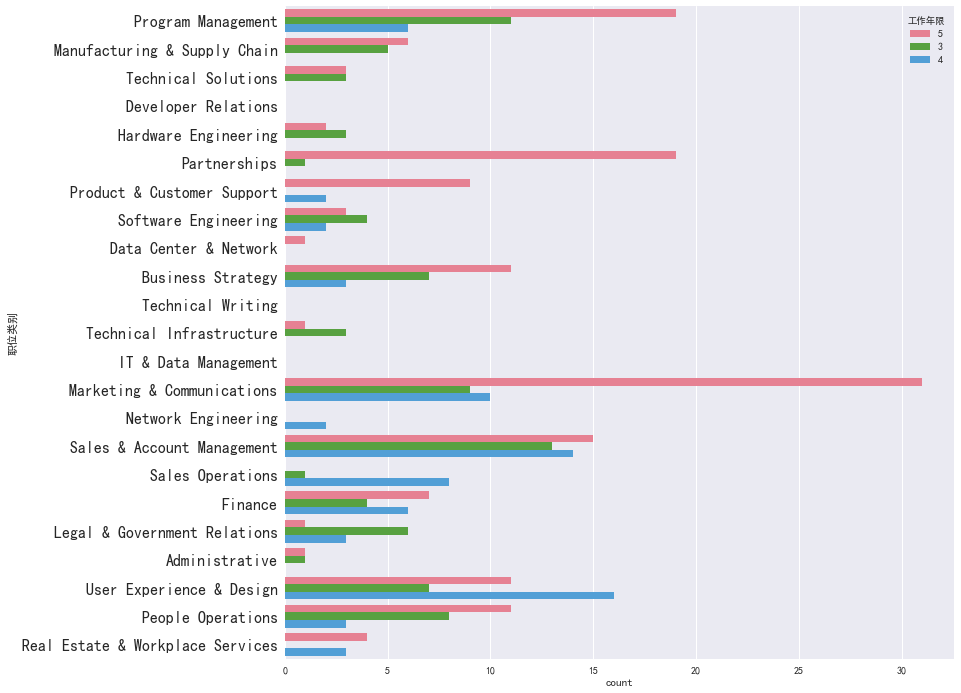

In [30]:
f, ax = plt.subplots(figsize=(12, 12))
with sns.color_palette("husl", 3):
    sns.countplot(y='职位类别', hue='工作年限', data=df_cate, 
                  hue_order=df_cate['工作年限'].value_counts().iloc[:3].index)
plt.yticks(fontsize=16)
plt.show()

In [31]:
# 设置停用词
STOPWORDS.add('degree')
STOPWORDS.add('name')
STOPWORDS.add('dtype')
STOPWORDS.add('location')
stopwords = set(STOPWORDS)

In [32]:
def word_cloud(df, series):
    """
        生成词云并保存为图片
        
        Args:
            df: DataFrame name, DataFrame
            series: Series name, string
    """
    mask = imread('img\google.jpg')
    
    wordcloud = WordCloud(
                                background_color = 'white',
                                stopwords = stopwords,
                                mask = mask,
                                max_font_size = 128, 
                                min_font_size = 8,
                                random_state = False
                            ).generate(str(df[series]))

    plt.figure(figsize = (12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();

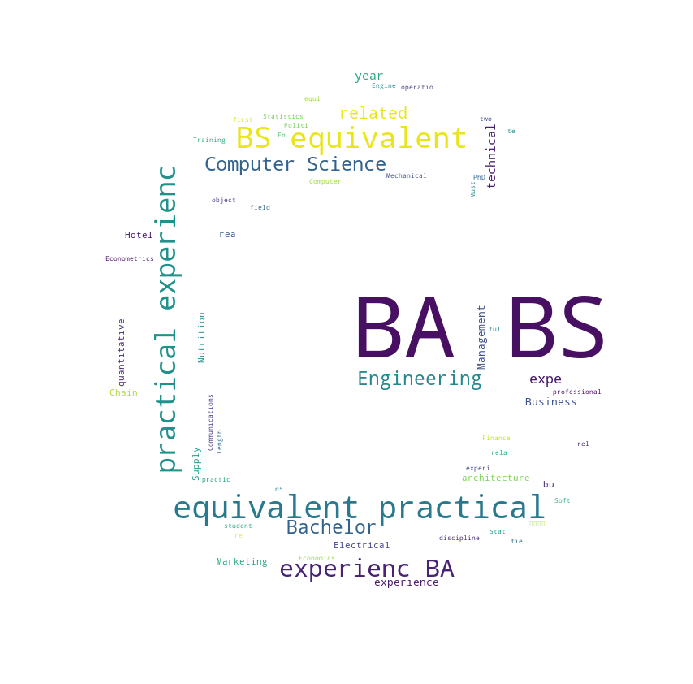

In [33]:
word_cloud(df, '最低资格')

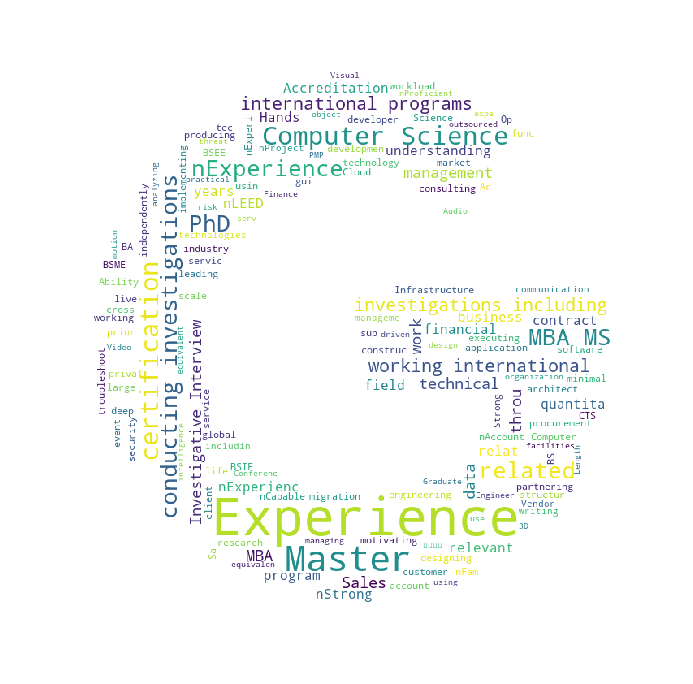

In [34]:
word_cloud(df, '首选资格')

In [35]:
df_TS = df[df['职位类别'] == 'Technical Solutions']

In [36]:
df_TS.describe()

,公司名称,职位名称,职位类别,工作地点,岗位职责,最低资格,首选资格,工作城市,工作国家,工作年限
count,100,100,100,100,100,100,100,100,100,18
unique,1,59,1,39,63,63,62,39,23,7
top,Google,"Partner Sales Engineer, Google Cloud",Technical Solutions,"Dublin, Ireland",Work with Partner Managers to identify and rec...,Bachelor's degree in Computer Science or a rel...,"Experience in, and understanding of, data and ...",Dublin,Germany,8
freq,100,7,100,11,7,7,7,11,17,4


In [37]:
df_TS.sample(3)

,公司名称,职位名称,职位类别,工作地点,岗位职责,最低资格,首选资格,工作城市,工作国家,工作年限
227,Google,"Internet of Things (IoT) Product Specialist, G...",Technical Solutions,"London, United Kingdom",Work as part of the Sales team to identify and...,"BA/BS degree in Computer Science, related soft...",Master's degree in Computer Science or other r...,London,United Kingdom,NaN
259,Google,"Customer Solutions Engineer, Google Technical ...",Technical Solutions,"Mumbai, India","Work closely with our sales team. Identify, de...",BA/BS degree in Computer Science or a related ...,MBA degree or Master’s degree in Computer Scie...,Mumbai,India,NaN
14,Google,"Solution Architect, Google Cloud Platform (Api...",Technical Solutions,"Amsterdam, Netherlands","Produce required design specifications, provid...",BA/BS degree in a technical or engineering fie...,Experience with or deep understanding of priva...,Amsterdam,Netherlands,NaN


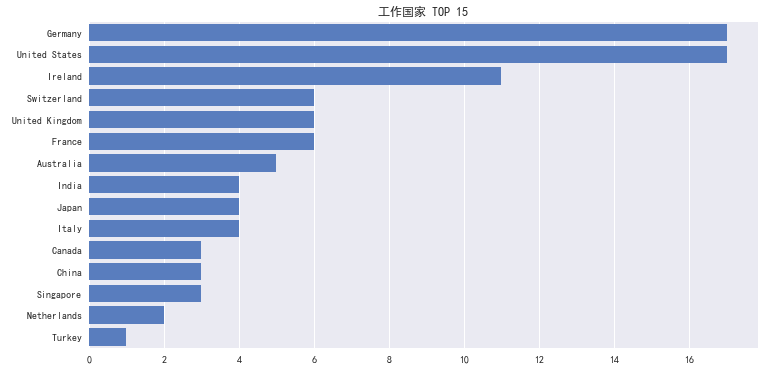

In [38]:
top15_bar(df_TS, '工作国家')

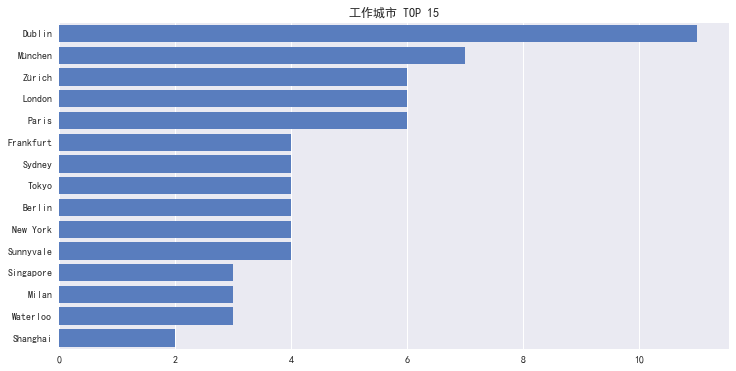

In [39]:
top15_bar(df_TS, '工作城市')

In [40]:
TS_minimum_qualifications = tostr(df_TS, '最低资格')

In [41]:
TS_programming_lang_count = word_count(TS_minimum_qualifications, programing_language_list)

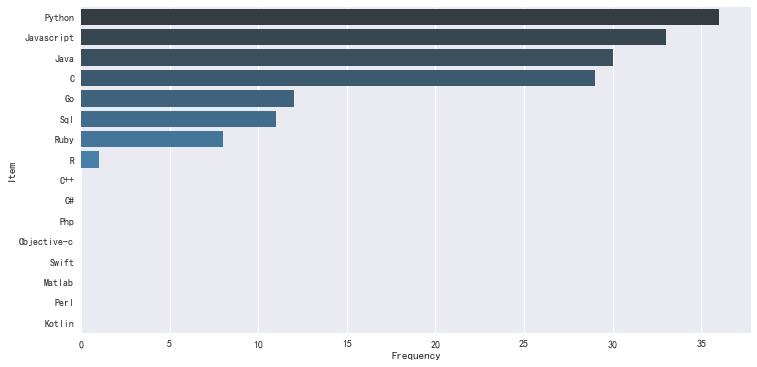

In [42]:
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="Frequency",  y="Item", data=TS_programming_lang_count, palette="Blues_d");

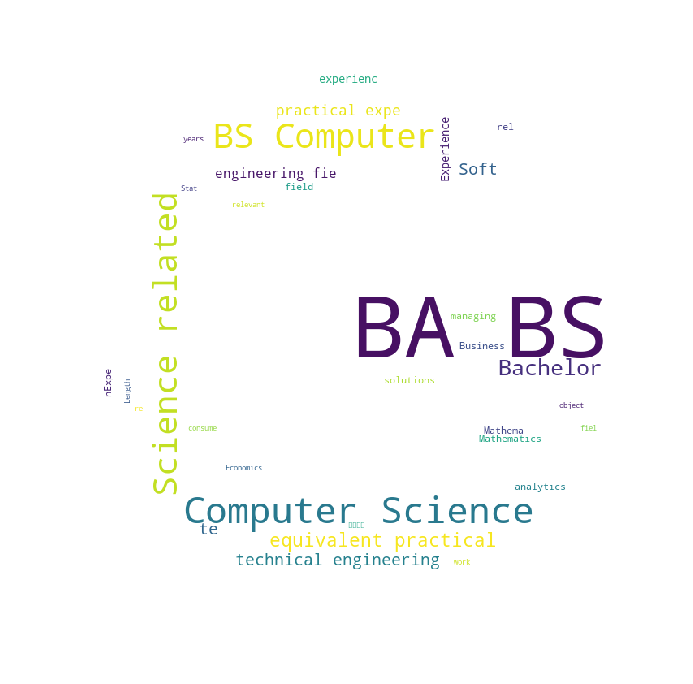

In [43]:
word_cloud(df_TS, '最低资格')

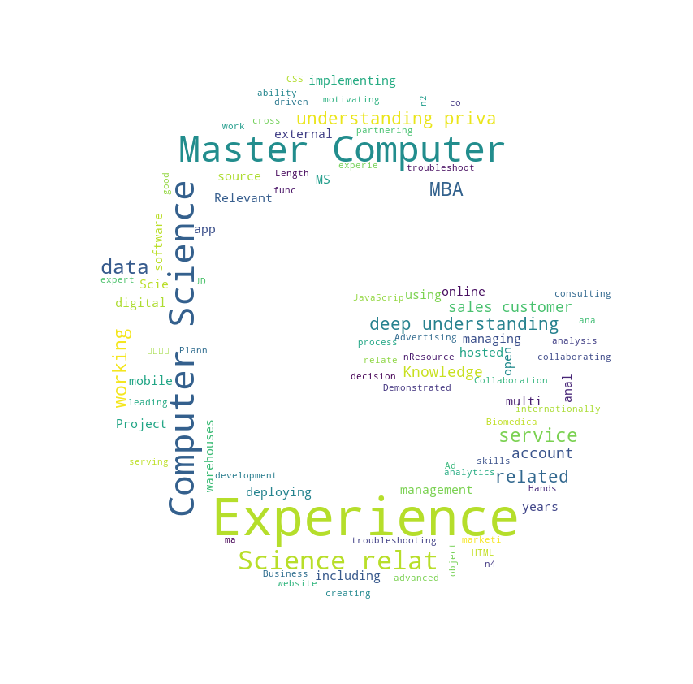

In [44]:
word_cloud(df_TS, '首选资格')

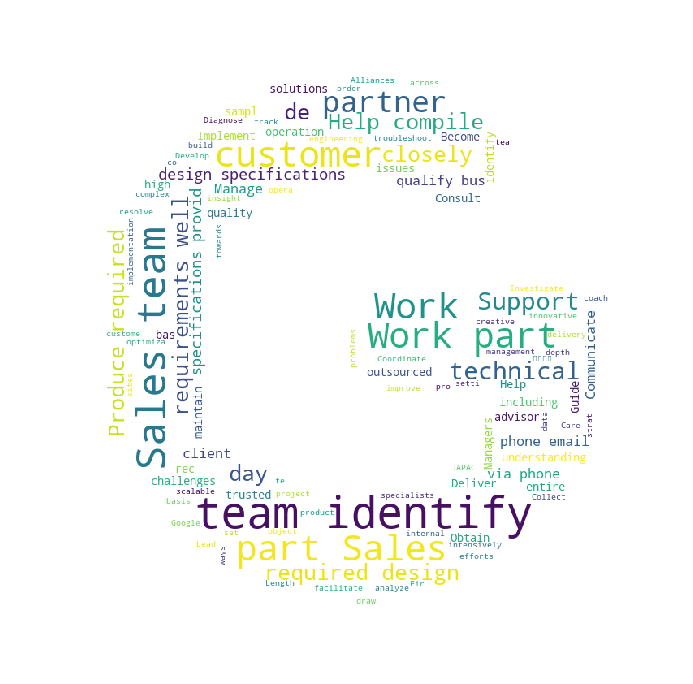

In [45]:
word_cloud(df_TS, '岗位职责')